In [ ]:
https://rdrr.io/cran/survival/man/flchain.html
https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.datasets.load_flchain.html
https://notebook.community/sebp/scikit-survival/examples/evaluating-survival-models

In [ ]:
!pip install lifelines
!pip install osqp==0.5
!pip install scikit-survival
!pip install pycox
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.7/349.7 KB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 KB 4.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=136e5d1281012de6a13a851249b4336a35006d068582443eaaa5a364fee6c34a
  Stored in directory: /root/.cache/pip/wheels/16/a2/b6/582cfdfbeeccd469504a01af3bb952fd9e7eccba40995eafea
Successfully built autograd-gamma
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.0/209.0 KB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for osqp: filename=osqp-0.5.0-cp38-cp38-linux_x86_64.whl size=197472 sha256=56d34c28cdf28a371f4588cafef7ad057f63b5856f62fbd63afbdd6243d72a71
  Stored in dir

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
from torch.distributions.weibull import Weibull
from torch.distributions.log_normal import LogNormal
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all
import math
from numbers import Real
from numbers import Number
from einops import rearrange
import pandas as pd
import numpy as np
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lifelines.utils import concordance_index# as c_index
from sksurv.metrics import brier_score, integrated_brier_score, concordance_index_censored as ci_scikit
from copy import copy, deepcopy
import dask
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True

Mounted at /content/drive


RuntimeError: ignored

In [ ]:
def non_censored_diagn(data, E, T, mlt, step):
    errors, churned = [], np.where(E)[0]
    bins = np.arange(min(T.iloc[churned]), max(T.iloc[churned]), step)
    for i in range(len(bins)-1):
        idx = data_test.loc[(data[event_column]==1) & (data[time_column]>=bins[i]) & (data[time_column]<=bins[i+1])].index.values
        errors.append(mean_absolute_error(T_test.iloc[idx], mlt[idx]))
    fig = make_subplots(rows=3, cols=1)
    # Add traces
    fig.append_trace(go.Scatter(x=T.iloc[churned].index, y=T.iloc[churned], mode='markers', name='TRUE'), row=1, col=1)
    fig.append_trace(go.Scatter(x=T.iloc[churned].index, y=mlt[churned], mode='markers', name='PRED'), row=1, col=1)
    fig.append_trace(go.Scatter(x=T.iloc[churned].index, y=np.abs(T.iloc[churned] - mlt[churned]), mode='lines', name='ERROS'), row=1, col=1)
    fig.append_trace(go.Scatter(x=[0, max(T.iloc[churned].index)], y=[mean_absolute_error(T.iloc[churned], mlt[churned])]*2, mode='lines', name='MAE'), row=1, col=1)
    fig.append_trace(go.Scatter(x=[0, max(T.iloc[churned].index)], y=[np.median(np.abs(T.iloc[churned] - mlt[churned]))]*2, mode='lines', name='MEDIAN'), row=1, col=1)
    fig.append_trace(go.Histogram(x=np.abs(T.iloc[churned] - mlt[churned]), histnorm='probability'), row=2, col=1)
    fig.append_trace(go.Scatter(x=bins[1:], y=errors), row=3, col=1)
    fig.update_layout(height=750)
    return fig

def plot_surv(idx, T, mlt, surv, times, vs=0.05):
    rows, cols, k = int(np.ceil(len(idx)/3)), 3, 0
    subplot_titles = ['Survival curve of '+str(c) for c in idx]
    surv_plot = make_subplots(rows=rows, cols=cols, shared_yaxes=True, subplot_titles=subplot_titles, horizontal_spacing = 0.01, vertical_spacing=vs)
    for i in range(rows):
        for j in range(cols):
          surv_plot.add_trace(go.Scatter(x=times, y=surv[:,idx[k]].flatten(), name=str(idx[k]), line=dict(color='#0000ff')), row=i+1, col=j+1)
          surv_plot.add_trace(go.Scatter(x=[T[idx[k]]]*10, y=np.linspace(0,1,10), mode='lines', line=dict(color='#ff0000')), row=i + 1, col=j + 1)
          surv_plot.add_trace(go.Scatter(x=[mlt[idx[k]]] * 10, y=np.linspace(0, 1, 10), mode='lines', line=dict(color='#00ff00')), row=i + 1, col=j + 1)
          k += 1
          if k >= len(idx):
            break
    surv_plot.update_layout(height=rows*300)
    return surv_plot

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/survival analysis/digital_marketing_churn/data1.csv', sep=';')
df[['avg order value','discount rate per visited products','product detail view per app session','add to cart per session']] = df[['avg order value','discount rate per visited products','product detail view per app session','add to cart per session']].replace({',':'.'},regex=True).apply(pd.to_numeric,1)
df

,account length,location code,user id,credit card info save,push status,add to wishlist,desktop sessions,app sessions,desktop transactions,total product detail views,session duration,promotion clicks,avg order value,sale product views,discount rate per visited products,product detail view per app session,app transactions,add to cart per session,customer service calls,churn
0,128,415,3824657,no,yes,25,265,45,17,110,197,87,244.7,91,11.01,10.0,3,2.70,1,0
1,107,415,3717191,no,yes,26,162,27,17,123,196,103,254.4,103,11.45,13.7,3,3.70,1,0
2,137,415,3581921,no,no,0,243,41,10,114,121,110,162.6,104,7.32,12.2,5,3.29,0,0
3,84,408,3759999,yes,no,0,299,51,5,71,62,88,196.9,89,8.86,6.6,7,1.78,2,0
4,75,415,3306626,yes,no,0,167,28,13,113,148,122,186.9,121,8.41,10.1,3,2.73,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,4144276,no,yes,36,156,27,18,77,216,126,279.1,83,12.56,9.9,6,2.67,2,0
3329,68,415,3703271,no,no,0,231,39,13,57,153,55,191.3,123,8.61,9.6,4,2.59,3,0
3330,28,510,3288230,no,no,0,181,31,25,109,289,58,191.9,91,8.64,14.1,6,3.81,2,0
3331,184,510,3646381,yes,no,0,214,36,14,105,160,84,139.2,137,6.26,5.0,10,1.35,2,0


In [ ]:
pd.DataFrame({'Dtype': df.dtypes, 'Nunique': df.nunique(), 'Isnull': df.isnull().sum()}, index=df.columns)

,Dtype,Nunique,Isnull
account length,int64,212,0
location code,int64,3,0
user id,int64,3333,0
credit card info save,object,2,0
push status,object,2,0
add to wishlist,int64,46,0
desktop sessions,int64,295,0
app sessions,int64,60,0
desktop transactions,int64,30,0
total product detail views,int64,119,0


In [ ]:
df.describe()

,account length,location code,user id,add to wishlist,desktop sessions,app sessions,desktop transactions,total product detail views,session duration,promotion clicks,avg order value,sale product views,discount rate per visited products,product detail view per app session,app transactions,add to cart per session,customer service calls,churn
count,3333.000000,3333.000000,3.333000e+03,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,3.746291e+06,8.099010,179.811881,30.567957,17.087609,100.435644,201.039604,100.110711,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,42.371290,2.746626e+05,13.688365,54.457135,9.269376,4.323795,20.069084,50.714359,19.923911,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,408.000000,3.271058e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,3.508680e+06,0.000000,144.000000,24.000000,14.000000,87.000000,167.000000,87.000000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,101.000000,415.000000,3.748187e+06,0.000000,179.000000,31.000000,17.000000,101.000000,201.000000,100.000000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,510.000000,3.985970e+06,20.000000,216.000000,37.000000,20.000000,114.000000,235.000000,114.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,510.000000,4.229964e+06,51.000000,351.000000,60.000000,31.000000,165.000000,364.000000,170.000000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


In [ ]:
time_column = 'account length'
event_column = 'churn'
to_remove = ['user id','app sessions', 'session duration', 'avg order value', 'add to cart per session']
features = [c for c in df.columns if (c not in [time_column, event_column]) and (c not in to_remove)]
categorical = [c for c in features if (df[c].dtype=='object') and (df[c].nunique() > 2)]
binary = [c for c in features if df[c].nunique() == 2]
numerical = [col for col in features if col not in categorical + binary]
df[numerical] = df[numerical].apply(pd.to_numeric,1)
df[time_column] = df[time_column]+0.1

#df = df.replace({event_column: {'Existing Customer': 0, 'Attrited Customer': 1}})
fig = go.Figure(data=go.Heatmap(z=df[numerical].corr(),x=numerical,y=numerical))
fig.show()

In [ ]:
from sklearn.model_selection import train_test_split

index_train, index_test = train_test_split(range(df.shape[0]), test_size=0.2, random_state=0, stratify=df[event_column])
tmp_data_train = df.loc[index_train].reset_index( drop = True )
data_test  = df.loc[index_test].reset_index( drop = True )

index_train, index_valid = train_test_split(tmp_data_train.index, test_size=0.15, random_state=0, stratify=tmp_data_train[event_column])
data_train = tmp_data_train.loc[index_train].reset_index( drop = True )
data_valid = tmp_data_train.loc[index_valid].reset_index( drop = True )

 
# Creating the X, T and E inputs
X_train, X_valid, X_test = data_train[features], data_valid[features], data_test[features]
T_train, T_valid, T_test = data_train[time_column], data_valid[time_column], data_test[time_column]
E_train, E_valid, E_test = data_train[event_column], data_valid[event_column], data_test[event_column]

cat_enc_d = {}
for cat in categorical+binary:
    print(cat)
    LE = LabelEncoder()
    X_train[cat] = LE.fit_transform(X_train[cat])
    X_valid[cat] = LE.transform(X_valid[cat])
    X_test[cat] = LE.transform(X_test[cat])
    cat_enc_d[cat] = LE
 
MS = MinMaxScaler(feature_range=(0, 1))
scaled_train = MS.fit_transform(X_train[numerical])
scaled_valid = MS.transform(X_valid[numerical])
scaled_test = MS.transform(X_test[numerical])
X_train[numerical], X_valid[numerical], X_test[numerical] = scaled_train, scaled_valid, scaled_test

X_train.shape, X_valid.shape, X_test.shape

credit card info save
push status


<ipython-input-10-6c700241f356>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-10-6c700241f356>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-10-6c700241f356>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3

((2266, 13), (400, 13), (667, 13))

In [ ]:
X_train

,location code,credit card info save,push status,add to wishlist,desktop sessions,desktop transactions,total product detail views,promotion clicks,sale product views,discount rate per visited products,product detail view per app session,app transactions,customer service calls
0,0.068627,0,0,0.000000,0.642651,0.451613,0.448485,0.446429,0.465649,0.648536,0.476190,0.15,0.222222
1,0.068627,0,0,0.000000,0.478386,0.548387,0.472727,0.529762,0.694656,0.512253,0.645503,0.30,0.000000
2,0.068627,0,0,0.000000,0.579251,0.451613,0.557576,0.541667,0.496183,0.607890,0.470899,0.35,0.111111
3,0.000000,0,0,0.000000,0.403458,0.741935,0.569697,0.547619,0.572519,0.444112,0.587302,0.45,0.111111
4,0.000000,1,0,0.000000,0.608069,0.290323,0.369697,0.708333,0.229008,0.411237,0.513228,0.20,0.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,0.000000,0,0,0.000000,0.371758,0.451613,0.672727,0.619048,0.488550,0.458458,0.544974,0.25,0.111111
2262,1.000000,0,0,0.000000,0.481268,0.612903,0.369697,0.636905,0.748092,0.497908,0.433862,0.30,0.777778
2263,1.000000,0,0,0.000000,0.440922,0.612903,0.642424,0.696429,0.908397,0.673042,0.470899,0.25,0.222222
2264,0.068627,0,0,0.000000,0.556196,0.483871,0.515152,0.625000,0.656489,0.286312,0.539683,0.05,0.000000


In [ ]:
from torch import autograd

def sinc(x):
    x = x * np.pi
    return torch.where(x != 0., torch.sin(x) / x, 1.)

class LogLogistic(ExponentialFamily):
    arg_constraints = {'scale': constraints.positive}
    support = constraints.positive
    #has_rsample = True

    @property
    def mean(self):
        mean = torch.exp(self.loc) / sinc(self.scale)
        return torch.where(self.scale > 1., np.nan, mean).to(device)

    @property
    def variance(self):
        variance = torch.exp(2 * self.loc) * (1. / sinc(2 * self.scale) - 1. / sinc(self.scale)**2)
        return torch.where(self.scale > 0.5, np.nan, variance)

    def __init__(self, loc, scale, validate_args=None):
        self.loc, self.scale = broadcast_all(loc, scale)
        if isinstance(loc, Number) and isinstance(scale, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.loc.size()
        super(LogLogistic, self).__init__(batch_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(LogLogistic, _instance)
        batch_shape = torch.Size(batch_shape)
        new.loc = self.loc.expand(batch_shape)
        new.scale = self.scale.expand(batch_shape)
        super(LogLogistic, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return ((value.log() - self.loc)/self.scale) - self.scale.log() - value.log() - 2*torch.log(1+torch.exp((value.log() - self.loc)/self.scale))

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return 1/(1+torch.exp(-(value.log() - self.loc)/self.scale))
 
class SURV_DATA_LOADER(Dataset):
    def __init__(self, X, T, E, numerical_col, categorical_col):
        self.X1, self.X2, self.T, self.E = X[numerical_col].values.astype(np.float32), X[categorical_col].values, T.astype(np.float32), E.astype(np.bool)
 
    def __len__(self):
        return len(self.E)
 
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.T[idx], self.E[idx]

class Embedder(nn.Module):
    def __init__(self, embedding_sizes):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])

    def forward(self, x):
        x = [e(x[:,i]) for i,e in enumerate(self.embeddings)]
        return torch.cat(x, 1)

class NNModel(nn.Module):
    def __init__(self, input_shape, units=None, factors=None, activ=True, norm=False, dropout=False, slops=None):
        super().__init__()
        self.input_shape = input_shape
        self.units = units
        self.factors = factors
        self.activ, self.norm = activ, norm
        self.network = nn.ModuleList()
        if self.factors:
            self.units = np.round(self.input_shape * np.asarray(self.factors)).astype(int)
        if self.units is not None:
            self.dropout = np.zeros_like(self.units) if not dropout else dropout
            self.slops = np.full(len(self.units), 1) if slops is None else slops
            for i, j, k in zip(self.units, self.dropout, self.slops):
                if i >= 1:
                    block = self.__build_block__(input_shape, i, p=j, slop=k)
                    self.network.extend(block)
                    input_shape = i
        self.output_shape = input_shape
        self.reset_parameters()
    
    def __build_block__(self, input_shape, units, p, slop):
        block = []
        block.append(nn.Linear(input_shape, units, bias=not self.norm))
        if self.norm:
            block.append(nn.BatchNorm1d(units))
            #block.append(nn.LayerNorm(units, eps=1e-5))
        if self.activ:
            #block.append(nn.LeakyReLU())
            block.append(nn.ELU(slop))
            #block.append(nn.GELU())
        if p > 0:
            block.append(nn.Dropout(p))
        return block
 
    def forward(self, x):
        for layer in self.network:
          tmp = layer(x)
          x = tmp
        return x
 
    def reset_parameters(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                layer.bias.data.fill_(0.1)
 
 
class TabMLP(nn.Module):
    def __init__(self, vocab_size, embed_size, numerical, mlp_units, mlp_dropout=0.00001):
        """
        categories: tuple containing the number of unique values within each category
        """
        super().__init__()
        embedding_sizes = list(zip(vocab_size, embed_size))
        self.cat_embedder = Embedder(embedding_sizes)
        self.norm = nn.BatchNorm1d(numerical, eps=1e-5)
        input_size = numerical + sum(embed_size)
        self.mlp = NNModel(int(input_size), units=mlp_units, factors=None, dropout=[mlp_dropout]*len(mlp_units))
        self.output_shape = mlp_units[-1]

    def forward(self, x_cont, x_cat):
        x = x_cont
        if x_cat.nelement() != 0: #skipped if there's no categorical feature
            x_ = self.cat_embedder(x_cat)
            x = self.norm(x)
            x = torch.cat([x_, x], 1)
        return self.mlp(x)

class MDN(nn.Module):
    def __init__(self, shared, clf_nn, alpha_nn, beta_nn, n_comp):
        super(MDN, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.shared = shared
        self.clf_nn = clf_nn
        self.alpha_nn = alpha_nn
        self.beta_nn = beta_nn
        self.n_comp = n_comp
        self.pi = nn.Linear(self.clf_nn.output_shape, self.n_comp) if self.n_comp > 1 else None
        self.ai = nn.Linear(self.alpha_nn.output_shape, self.n_comp)
        self.bi = nn.Linear(self.beta_nn.output_shape, self.n_comp)
 
    def forward(self, x_cont, x_cat):
        x = self.shared(x_cont, x_cat)
        proba = self.proba_model(x) if self.n_comp > 1 else torch.ones((len(x),1)).to(self.device)
        alpha = self.alpha_model(x)
        beta = self.beta_model(x)
        return proba, alpha, beta
 
    def proba_model(self, x):
        model = self.clf_nn(x)
        model = self.pi(model)
        model = nn.Softmax(dim=-1)(model)
        return model
 
    def alpha_model(self, x):
        model = self.alpha_nn(x)
        model = self.ai(model)
        return model
 
    def beta_model(self, x):
        model = self.beta_nn(x)
        model = self.bi(model)
        return model

class BaseParametric:
    def __init__(self, model, num_time_bins, numerical_col, categorical_col, resume=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.losses = {'Epoch': [], 'Train': [], 'Test': [], 'BState': [], 'LState': [], 'LR': []}
        self.num_time_bins = num_time_bins
        self.numerical_col, self.categorical_col = numerical_col, categorical_col
        self.times = None
        self.optim = resume
 
    def train_model(self, optim, train_loader, grad_clip, l2_reg):
          total_loss = 0
          self.model = self.model.train()
        #with autograd.detect_anomaly():
          for i, (X1, X2, T, E) in enumerate(train_loader):
              X1, X2, T, E = X1.to(self.device), X2.to(self.device), T.to(self.device), E.to(self.device)
              #self.model.get_weight()
              self.optim.zero_grad()
              loss = self.loss_function(X1, X2, T, E, l2_reg)
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
              self.optim.step()
              '''self.model.get_grad()
              print('_'*50)'''
              total_loss += loss.item()
          return total_loss/(i+1)
        
 
    def eval_model(self, test_loader):
        self.model = self.model.eval()
        total_loss = 0
        for i, (X1, X2, T, E) in enumerate(test_loader):
            X1, X2, T, E = X1.to(self.device), X2.to(self.device), T.to(self.device), E.to(self.device)
            loss = self.loss_function(X1, X2, T, E, l2_reg=0)
            total_loss += loss.item()
        return total_loss/(i+1)#np.abs(-100. - total_loss)
 
 
    def fit(self, X_train, T_train, E_train, epoch, lr, opt_kwarg, batch_size=None,  grad_clip=100, momentum=0.9, is_min_time_zero=False, extra_pct_time=0.1,
            X_test=None, T_test=None, E_test=None, l2_reg=0, eval=True, verbose=True, save=True):
        
        min_t = 0 if is_min_time_zero else min(T_train)
        max_t = max(T_train)*(1+extra_pct_time)
        self.times = np.linspace(min_t, max_t, self.num_time_bins)
 
        batch_size = len(X_train) if batch_size is None else batch_size
        #X_train_uncens, Y_train_uncens, T_train_uncens, X_train_cens, Y_train_cens, T_train_cens = self.process_data(X_train, T_train, E_train)
        train_load = DataLoader(SURV_DATA_LOADER(X_train, T_train, E_train, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        if X_test is not None:
            #X_test_uncens, Y_test_uncens, T_test_uncens, X_test_cens, Y_test_cens, T_test_cens = self.process_data(X_test, T_test, E_test)
            test_load = DataLoader(SURV_DATA_LOADER(X_test, T_test, E_test, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
 
        best_loss = 1e100
        #self.optim = opt.Adam(self.model.parameters(), lr=lr)
        self.optim = opt.SGD(self.model.parameters(), lr=lr, momentum=momentum, nesterov=True)

        #scheduler = None
        scheduler = opt.lr_scheduler.CyclicLR(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.ReduceLROnPlateau(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.MultiStepLR(self.optim, milestones=[28, 120], gamma=0.1)

        eval_score = ''
        for i in range(epoch):
            if verbose:
                print('##### EPOCH ' + str(i) + ' #####')
               
            train_loss = self.train_model(self.optim, train_load, grad_clip, l2_reg)
            self.losses['LState'] = deepcopy(self.model.state_dict())
    
            if verbose:
                print('train loss : ', train_loss)
            self.losses['Epoch'].append(i), self.losses['Train'].append(train_loss)
    
            if X_test is not None:
                valid_loss = self.eval_model(test_load)

                if verbose:
                    print('test loss : ', valid_loss)
                self.losses['Test'].append(valid_loss)
    
                if scheduler is not None:
                    '''scheduler.step(valid_loss)
                    self.losses['LR'].append(self.optim.param_groups[0]['lr'])'''
                    scheduler.step()
                    self.losses['LR'].append(scheduler.get_last_lr()[0])
    
                if valid_loss < best_loss:
                    self.losses['BState'] = deepcopy(self.model.state_dict())
                    best_loss = valid_loss
                    print('===========SAVE===========')
                    
 
    def b_index(self, X_train, T_train, E_train, X_test, T_test, E_test, survival, plot=True):
        time_idx = self.times[np.argmin(self.times<min(T_test)):np.argmax(self.times>max(T_test)) - 1] #don't keep times index that are beyond max(T_train)
        train_e_t = np.asarray(list(zip(E_train.astype(np.bool), T_train)), dtype='|bool, i4') #concat event and time
        test_e_t = np.asarray(list(zip(E_test.astype(np.bool), T_test)), dtype='|bool, i4')
        brier_res = []
        for j, i in enumerate(time_idx):
            _, score = brier_score(train_e_t, test_e_t, survival[:,j], i)
            brier_res.append(score[0])
        ibs = np.trapz(brier_res, time_idx)/max(T_train)
        if plot:
            figure = self.plot_brier_curve(time_idx, brier_res, ibs)
            return brier_res, ibs, figure
        else:
            return brier_res, ibs

    def c_index(self, mlt, t, e):
        #mlt = torch.sum(p * alpha * torch.lgamma(1 + (1/beta)).exp(), 1).cpu().data.numpy() #WEIBULL
        #mlt = torch.sum(p * torch.exp(alpha + torch.pow(beta, 2)/2), 1).data.numpy() #LOGNORMAL
        res = 1 - ci_scikit(e.astype(np.bool), t, mlt)[0]
        return res
 
    def plot_brier_curve(self, time_axis, score, ibs):
        fig, ax = plt.subplots(figsize=(8, 4))
        plt.plot(time_axis, score, color='blue', label='Brier score / time', lw=2)
 
        plt.axhline(y=0.25, color='black', linestyle='-')
        #ax.annotate('0.25', xy=(1, 0.5), xytext=(t, 0.5), fontsize=12)
 
        title = "Integrated Brier Score: " + str(ibs)
        plt.legend(fontsize=12)
        plt.title(title, fontsize=15)
        plt.ylim(0, 1.05)
        return plt

    def feature_importance(self, rep, X_test, T_test, E_test, batch_size=None):
        res = np.zeros((rep, X_test.shape[1]))
        batch_size = len(X_train) if batch_size is None else batch_size
        test_load = DataLoader(SURV_DATA_LOADER(X_test, T_test, E_test, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        base_loss = self.eval_model(test_load)
        origin = X_test.copy()
        for i, col in enumerate(X_test.columns):
            for j in range(rep):
                X_test.loc[:,col] = np.random.permutation(X_test.loc[:, col])
                test_load = DataLoader(SURV_DATA_LOADER(X_test, T_test, E_test, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
                loss = self.eval_model(test_load)
                res[j, i] = base_loss - loss
                X_test = origin
        res = np.abs(res)
        return {'importances': res, 'importances_mean': np.mean(res, 0), 'importances_std': np.std(res, 0)}

class WeibullModel(BaseParametric):
    def __init__(self, model, num_time_bins, numerical_col, categorical_col,resume=None):
        super(WeibullModel, self).__init__(model, num_time_bins, numerical_col, categorical_col,)

    def loss_function(self, X1, X2, T, E, l2_reg):
        pi, alpha, beta = self.model(X1, X2)
        alpha = nn.ELU()(alpha) + 1 + 1e-15 #WEIBULL
        beta = nn.ELU()(beta) + 2 #WEIBULL
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        loss = torch.where(E, mixture.log_prob(T), torch.log(torch.clamp(1 - mixture.cdf(T), min=1e-25)))
        loss = -torch.mean(loss)
        return loss

    def prdict_survival(self, X):
        self.model.eval()
        X1 = torch.tensor(X[self.numerical_col].values.astype(np.float32)).to(self.device)
        X2 = torch.tensor(X[self.categorical_col].values).to(self.device)
        T = (torch.FloatTensor(self.times[:,np.newaxis,np.newaxis].astype(np.float32)) + 1e-5).to(self.device)
        pi, alpha, beta = self.model(X1, X2)
        alpha = nn.ELU()(alpha) + 1 + 1e-15 #WEIBULL
        beta = nn.ELU()(beta) + 2 #WEIBULL
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        surv = 1 - mixture.cdf(T)
        return pi, alpha, beta, surv, mixture.mean

class LogNormalModel(BaseParametric):
    def __init__(self, model, num_time_bins, numerical_col, categorical_col,resume=None):
        super(LogNormalModel, self).__init__(model, num_time_bins, numerical_col, categorical_col,)

    def loss_function(self, X1, X2, T, E, l2_reg):
        pi, mu, std = self.model(X1, X2)
        std = nn.ELU()(std) + 1 + 1e-15 #LOGNORMAL
        mix = Categorical(pi)
        comp = LogNormal(mu, std, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        loss = torch.where(E, mixture.log_prob(T), torch.log(torch.clamp(1 - mixture.cdf(T), min=1e-25)))
        loss = -torch.mean(loss)
        return loss

    def prdict_survival(self, X):
        self.model.eval()
        X1 = torch.tensor(X[self.numerical_col].values.astype(np.float32)).to(self.device)
        X2 = torch.tensor(X[self.categorical_col].values).to(self.device)
        T = (torch.FloatTensor(self.times[:,np.newaxis,np.newaxis].astype(np.float32)) + 1e-5).to(self.device)
        pi, mu, std = self.model(X1, X2)
        std = nn.ELU()(std) + 1 + 1e-15 #LOGNORMAL
        mix = Categorical(pi)
        comp = LogNormal(mu, std, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        surv = 1 - mixture.cdf(T)
        return pi, mu, std, surv, mixture.mean

class LogLogisticModel(BaseParametric):
    def __init__(self, model, num_time_bins, numerical_col, categorical_col,resume=None):
        super(LogLogisticModel, self).__init__(model, num_time_bins, numerical_col, categorical_col,)

    def loss_function(self, X1, X2, T, E, l2_reg):
        pi, mu, std = self.model(X1, X2)
        mu = torch.where(mu>0, torch.tanh(mu), mu)
        std = ((1 - torch.exp(-torch.sigmoid(std))) * 0.5) #MAKE STD BETWEEN 0 AND 0.5
        mix = Categorical(pi)
        comp = LogLogistic(mu, std, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        loss = torch.where(E, mixture.log_prob(T), torch.log(torch.clamp(1 - mixture.cdf(T), min=1e-25)))
        loss = -torch.mean(loss)
        return loss

    def prdict_survival(self, X):
        self.model.eval()
        X1 = torch.tensor(X[self.numerical_col].values.astype(np.float32)).to(self.device)
        X2 = torch.tensor(X[self.categorical_col].values).to(self.device)
        T = (torch.FloatTensor(self.times[:,np.newaxis,np.newaxis].astype(np.float32)) + 1e-5).to(self.device)
        pi, mu, std = self.model(X1, X2)
        mu = torch.where(mu>0, torch.tanh(mu), mu)
        std = ((1 - torch.exp(-torch.sigmoid(std))) * 0.5) #MAKE STD BETWEEN 0 AND 0.5
        mix = Categorical(pi)
        comp = LogLogistic(mu, std, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        surv = 1 - mixture.cdf(T)
        return pi, mu, std, surv, mixture.mean
 
def gradient_clipper(model: nn.Module, val: float) -> nn.Module:
    def process_grad(grad):
        grad[grad != grad] = 1e-10
        return torch.clamp(grad, -val, val)
    for parameter in model.parameters():
        parameter.register_hook(lambda grad: process_grad(grad))
    
    return model

In [34]:
n_comp, epoch, lr, batch_size, d, mlp_d = 2, 50000, 1e-4, None, 0.000001, 0.3
cyclic_kwarg = {'base_lr': lr, 'max_lr': 1e-1, 'step_size_up':200, 'step_size_down':200}
plateau_kwarg = {'factor':0.5, 'patience':200, 'verbose':True, 'min_lr':1e-7, 'mode':'min'}
embed_size = np.ceil(np.sqrt(list(X_train[categorical+binary].nunique()))).astype(int)

shared_nn = TabMLP(df[categorical+binary].nunique(), embed_size, len(numerical), [128, 512, 768, 512], mlp_dropout=mlp_d)
clf_nn = NNModel(shared_nn.output_shape , units=[128], factors=None, dropout=[mlp_d])
alpha_nn = NNModel(shared_nn.output_shape, units=[128], factors=None, dropout=[mlp_d])
beta_nn = NNModel(shared_nn.output_shape, units=[128], factors=None, dropout=[mlp_d])#, dropout=[d,d,d,d]

nn_model = gradient_clipper(MDN(shared_nn, clf_nn, alpha_nn, beta_nn, n_comp), 10)
#nn_model.load_state_dict(best_state)
print(nn_model)
print(sum(p.numel() for p in nn_model.parameters() if p.requires_grad))
dws = LogNormalModel(nn_model, int(T_train.max()*1.1), numerical, categorical+binary)
dws.fit(X_train, T_train.values, E_train.values, epoch, lr, cyclic_kwarg, batch_size=batch_size, grad_clip=10, momentum=0.9,
        X_test=X_valid, T_test=T_valid.values, E_test=E_valid.values, l2_reg=0, eval=False, verbose=True, is_min_time_zero=True, extra_pct_time=0.1)

MDN(
  (shared): TabMLP(
    (cat_embedder): Embedder(
      (embeddings): ModuleList(
        (0): Embedding(2, 2)
        (1): Embedding(2, 2)
      )
    )
    (norm): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (mlp): NNModel(
      (network): ModuleList(
        (0): Linear(in_features=15, out_features=128, bias=True)
        (1): ELU(alpha=1)
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=128, out_features=512, bias=True)
        (4): ELU(alpha=1)
        (5): Dropout(p=0.3, inplace=False)
        (6): Linear(in_features=512, out_features=768, bias=True)
        (7): ELU(alpha=1)
        (8): Dropout(p=0.3, inplace=False)
        (9): Linear(in_features=768, out_features=512, bias=True)
        (10): ELU(alpha=1)
        (11): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (clf_nn): NNModel(
    (network): ModuleList(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): ELU(alpha=1)
     

<ipython-input-34-bbaa2d69882c>:14: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

<ipython-input-12-78887f3f6ff7>:51: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Streaming output truncated to the last 5000 lines.
test loss :  0.8437300324440002
##### EPOCH 1567 #####
train loss :  0.8414615988731384
test loss :  0.8438769578933716
##### EPOCH 1568 #####
train loss :  0.849629819393158
test loss :  0.8433786034584045
##### EPOCH 1569 #####
train loss :  0.8541139364242554
test loss :  0.8435716032981873
##### EPOCH 1570 #####
train loss :  0.8499942421913147
test loss :  0.843305766582489
##### EPOCH 1571 #####
train loss :  0.850526750087738
test loss :  0.843579113483429
##### EPOCH 1572 #####
train loss :  0.8497915267944336
test loss :  0.8430963158607483
##### EPOCH 1573 #####
train loss :  0.8503190875053406
test loss :  0.8430590629577637
##### EPOCH 1574 #####
train loss :  0.8460503816604614
test loss :  0.8435380458831787
##### EPOCH 1575 #####
train loss :  0.8405573964118958
test loss :  0.8436572551727295
##### EPOCH 1576 #####
train loss :  0.8451332449913025
test loss :  0.844187319278717
##### EPOCH 1577 #####
train loss :  0.841

KeyboardInterrupt: ignored

In [35]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

best_state = deepcopy(dws.losses['BState'])
dws.model.load_state_dict(best_state)
print(np.min(dws.losses['Test']))

fig = make_subplots(rows=3, cols=1)
s = 0
model = dws
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['Train'][s:],mode='lines',name='Train'), row=1, col=1)
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['Test'][s:],mode='lines',name='Test'), row=2, col=1)
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['LR'][s:],mode='lines',name='LR'), row=3, col=1)
fig.update_layout(height=1000, width=1500, title_text="Stacked Subplots")
fig.show()

0.8385435342788696


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning:

pylab import has clobbered these variables: ['std', 'figure', 'pi']
`%matplotlib` prevents importing * from pylab and numpy

<ipython-input-12-78887f3f6ff7>:267: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-12-78887f3f6ff7>:268: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20

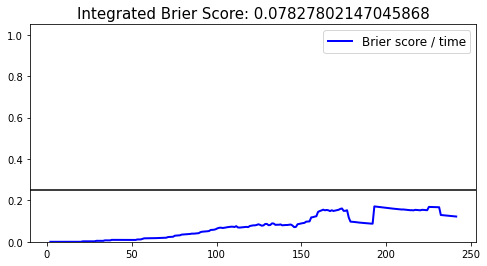

0.8840608531371185


<ipython-input-12-78887f3f6ff7>:283: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [36]:
from matplotlib import pyplot as plt
%pylab inline

pi, mu, std, survival_predictions, mlt = dws.prdict_survival(X_valid)
pi, mu, std, survival_predictions, mlt = pi.cpu(), mu.cpu(), std.cpu(), survival_predictions.cpu(), mlt.cpu().data.numpy()
survival_predictions = np.squeeze(survival_predictions.data.numpy())

brier_res, ibs, figure = dws.b_index(X_train.values, T_train, E_train.astype(float), X_valid.values, T_valid, E_valid.astype(float), survival_predictions.T, plot=True)
figure.show()
c_index = dws.c_index(mlt, T_valid, E_valid)
print(c_index)

<ipython-input-12-78887f3f6ff7>:267: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-12-78887f3f6ff7>:268: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



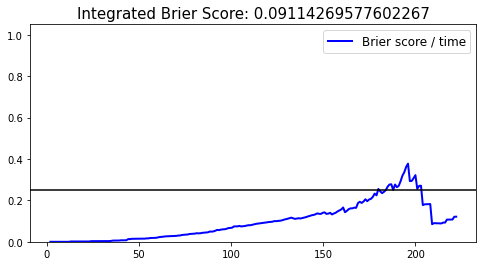

0.8772183177690062


<ipython-input-12-78887f3f6ff7>:283: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [37]:
pi, mu, std, survival_predictions, mlt = dws.prdict_survival(X_test)
pi, mu, std, survival_predictions, mlt = pi.cpu(), mu.cpu(), std.cpu(), survival_predictions.cpu(), mlt.cpu().data.numpy()
survival_predictions = np.squeeze(survival_predictions.data.numpy())

brier_res, ibs, figure = dws.b_index(X_train.values, T_train, E_train.astype(float), X_test.values, T_test, E_test.astype(float), survival_predictions.T, plot=True)
figure.show()
c_index = dws.c_index(mlt, T_test, E_test)
print(c_index)

In [38]:
non_censored_diagn(data_test, E_test, T_test, mlt, 30).show()

In [39]:
pd.DataFrame(data={'Event': E_test, 'True': T_test, 'PRED': mlt})

,Event,True,PRED
0,0,94.2,603.974670
1,1,40.2,69.101479
2,0,68.2,644.697510
3,0,121.2,920.356018
4,0,94.2,168.730255
...,...,...,...
662,1,125.2,169.052597
663,0,79.2,273.117798
664,0,79.2,459.007263
665,0,90.2,356.936493


In [43]:
idx = data_test.loc[(data_test[event_column]==1) & (data_test[time_column]>=100) & (data_test[time_column]<=130)].index.values
plot_surv(idx, T_test, mlt, survival_predictions, dws.times, vs=0.05).show()

In [41]:
imp = dws.feature_importance(10, X_test, T_test, E_test, batch_size=None)
fig = go.Figure()
for i in range(X_test.shape[1]):
    fig.add_trace(go.Box(x=imp['importances'][:, i], name=X_test.columns[i]))
fig.show()

<ipython-input-12-78887f3f6ff7>:51: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
pi

tensor([[2.2578e-04, 9.9955e-01, 2.2277e-04],
        [3.4043e-05, 9.9992e-01, 4.8371e-05],
        [1.1528e-04, 9.9975e-01, 1.3333e-04],
        ...,
        [7.7862e-04, 9.9774e-01, 1.4767e-03],
        [1.4006e-04, 9.9971e-01, 1.5303e-04],
        [4.8966e-04, 9.9899e-01, 5.2392e-04]], grad_fn=<SoftmaxBackward0>)